In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#Load the data
df = pd.read_csv('tmdb_metadata.csv', delimiter=',')

range of overview lengths: 178 - 3
mean of overview lengths: 53.8396572827


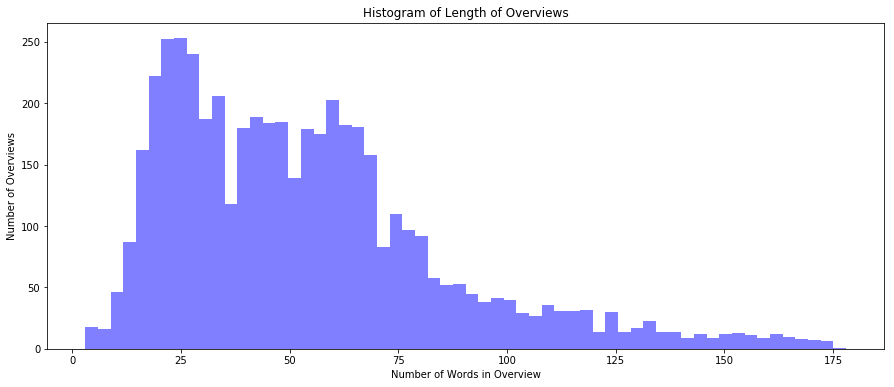

In [2]:
# Analysis of length of overview
# #Break each posts into words and count the number of words
lengths = df['overview'].apply(lambda x: len(x.split(' ')))

print 'range of overview lengths:', np.max(lengths), '-', np.min(lengths)
print 'mean of overview lengths:', np.mean(lengths)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Overview')
ax.set_ylabel('Number of Overviews')
ax.set_title('Histogram of Length of Overviews')

plt.show()

In [3]:
# boolean for including titles in text analysis
include_titles = 1

#Create a text vectorizer (turns text into array of numbers)
#using a common list of English stop words
vectorizer = CountVectorizer(stop_words='english', min_df=1)

### Top words over all genres
#Get all the text from data
corpus = df['overview'].values

if include_titles:
    titles = df['title'].values
    corpus = np.concatenate([corpus,titles])

#Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

#Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

print 'data shape:', x.shape
print 'some features:', feature_names[0:10]

#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

#Print the top n words and their frequencies
print top_words

data shape: (9804, 24041)
some features: [u'00', u'000', u'000th', u'007', u'009', u'01', u'03', u'05pm', u'10', u'100']
[(862, u'life'), (732, u'young'), (682, u'man'), (664, u'new'), (602, u'world'), (570, u'love'), (518, u'family'), (490, u'story'), (462, u'old'), (462, u'time'), (438, u'film'), (405, u'woman'), (383, u'years'), (368, u'father'), (348, u'finds'), (348, u'year'), (331, u'home'), (331, u'school'), (325, u'girl'), (321, u'war')]


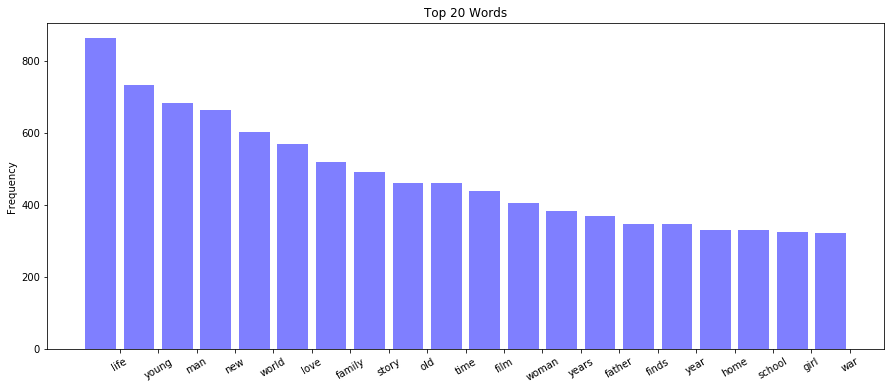

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [8]:
### Top words in each genre
# contains top words of each genre, index is the same as the labels column in Jason's dataset
genre_top_words_counts = []
genre_top_words = []

def getTopWordsOfGenre(genre):
    #get movies with this genre
    key = 3*genre + 1
    b = df['labels'].str.get(key) == '1'
    df2 = df[b]

    #Number of top words per genre
    n_top = 100

    #Get all the text from data
    corpus2 = df2['overview'].values
    if include_titles:
        titles = df2['title'].values
        corpus2 = np.concatenate([corpus2,titles])

    #Turn each text into an array of word counts
    x2 = vectorizer.fit_transform(corpus2)
    x2 = x2.toarray()
    
    #Get the names of all the words we're counting
    feature_names2 = vectorizer.get_feature_names()

    #Count the number of time each word occurs in the entire dataset
    word_freq2 = x2.sum(axis=0)

    #Sort the words by their total frequency in the dataset
    words2 = zip(word_freq2, feature_names2)
    top = (sorted(words2, key=lambda t: t[0], reverse=True))[:n_top]
    top_array = np.asarray(zip(*top)[1])
    genre_top_words_counts.append(top)
    genre_top_words.append(top_array)
    
n_genres = 19
for i in range(n_genres):
    getTopWordsOfGenre(i)

In [9]:
### creating dataframe for each movie and genre words frequency
genre_top_words_flattened = np.array(genre_top_words).flatten()
genre_top_words_flattened = np.unique(genre_top_words_flattened)

def count_freq(overview):
    #Turn each text into an array of word counts
    x3 = vectorizer.fit_transform(overview)
    x3 = x3.toarray()
    
    #Get the names of all the words we're counting
    feature_names3 = vectorizer.get_feature_names()

    #Count the number of time each word occurs in the entire dataset
    word_freq3 = x3.sum(axis=0)
    words3 = zip(word_freq3, feature_names3)
    df_freq = pd.DataFrame(words3, columns=['Freq', 'Feature'])

    counts = []
    for i in range(len(genre_top_words_flattened)):
        word_count = df_freq[df_freq['Feature'] == genre_top_words_flattened[i]]
        if word_count.empty:
            counts.append(0)
        else:
            val = df_freq[df_freq['Feature'] == genre_top_words_flattened[i]]['Freq'].iloc[0]
            counts.append(val)
    return counts

movie_words_freq = []
for i in range(len(df)):
    corpus3= df['overview'][i:(i+1)].values
    if include_titles:
        titles = df['title'][i:(i+1)].values
        corpus3= np.concatenate([corpus3,titles])
    a = count_freq(corpus3)
    movie_words_freq.append(a)

In [10]:
df_genre_word = pd.DataFrame(movie_words_freq, columns=genre_top_words_flattened)
df_genre_word.to_csv('genre_words.csv', encoding = 'utf-8')

In [38]:
from sklearn.decomposition import PCA
x_text = df_genre_word.values
pca = PCA(n_components = 300)
pca.fit(x_text)
text_pca = pca.transform(x_text)

In [44]:
print "explained variance: " + str(sum(pca.explained_variance_ratio_))
df_genre_word_pca = pd.DataFrame(text_pca)
df_genre_word_pca.to_csv('genre_words_pca.csv', encoding = 'utf-8')

explained variance: 0.903391526261
